# Tutorial: Goal 3 - Similarity-Filtered Predictions

This tutorial guides you through two advanced prediction strategies:

1. **LSFT (Local Similarity-Filtered Training)**: Filter training data by similarity, retrain model
2. **LOGO (Functional Class Holdout)**: Hold out functional classes, test biological extrapolation

## Dataset

We'll use the **Adamson dataset** throughout this tutorial (smallest, fastest dataset).


## Part A: Local Similarity-Filtered Training (LSFT)

**LSFT** improves predictions by:
1. For each test perturbation, compute similarity to all training perturbations (in embedding space)
2. Filter training perturbations to top K% most similar (e.g., 1%, 5%, 10%)
3. Retrain the full model (Y = A·K·B) using only filtered training data
4. Evaluate on test perturbation
5. Compare to baseline (trained on all data)

The key idea: **Use only the most similar training examples for each test case.**


## Part A: Setup and Data Loading


In [ ]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr, spearmanr
import json
import warnings
warnings.filterwarnings('ignore')

# Set up paths
NOTEBOOK_DIR = Path.cwd()
EVAL_FRAMEWORK_DIR = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == "tutorials" else NOTEBOOK_DIR
if NOTEBOOK_DIR.name == "tutorials":
    sys.path.insert(0, str(EVAL_FRAMEWORK_DIR / "src"))

# Dataset paths
ADAMSON_DATA_PATH = EVAL_FRAMEWORK_DIR.parent / "paper" / "benchmark" / "data" / "gears_pert_data" / "adamson" / "perturb_processed.h5ad"
SPLIT_CONFIG_PATH = EVAL_FRAMEWORK_DIR / "results" / "goal_2_baselines" / "splits" / "adamson_split_seed1.json"
ANNOTATION_PATH = EVAL_FRAMEWORK_DIR / "data" / "annotations" / "adamson_functional_classes_enriched.tsv"
OUTPUT_DIR = EVAL_FRAMEWORK_DIR / "tutorials" / "outputs"
INPUT_DIR = OUTPUT_DIR

# Create output directory if it doesn't exist
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Ask user: Use real data or synthetic data?
print("="*70)
print("DATA SOURCE SELECTION")
print("="*70)
print("Choose a data source:")
print("  1. Real data: Load from Adamson dataset or previous notebook output")
print("  2. Synthetic data: Generate synthetic data (no downloads required)")
print()
USE_REAL_DATA = input("Enter choice (1 for real data, 2 for synthetic): ").strip()
USE_REAL_DATA = USE_REAL_DATA == "1" or USE_REAL_DATA.lower() == "real"

if USE_REAL_DATA:
    # Check if Y_train/Y_test exist from previous notebook
    prev_y_train = INPUT_DIR / "goal_2_Y_train.csv"
    prev_y_test = INPUT_DIR / "goal_2_Y_test.csv"
    if prev_y_train.exists() and prev_y_test.exists():
        print(f"\n✓ Found previous outputs: {prev_y_train}, {prev_y_test}")
        print("  Will load Y_train and Y_test from Goal 2 tutorial")
        USE_PREV_OUTPUT = True
    else:
        USE_PREV_OUTPUT = False
        print("\n✓ Using REAL DATA (loading from files)")
        print(f"  Adamson data: {ADAMSON_DATA_PATH}")
        print(f"  Split config: {SPLIT_CONFIG_PATH}")
        if not ADAMSON_DATA_PATH.exists() or not SPLIT_CONFIG_PATH.exists():
            print("\n⚠ WARNING: Required files not found. Switching to synthetic data.")
            USE_REAL_DATA = False
else:
    print("\n✓ Using SYNTHETIC DATA (no downloads required)")
    USE_PREV_OUTPUT = False

# Parameters (from Goal 2 tutorial - can reuse code)
pca_dim = 10
ridge_penalty = 0.1
seed = 1

# Helper functions from Goal 2
def solve_y_axb(Y, A, B, ridge_penalty):
    AtA = A.T @ A + ridge_penalty * np.eye(A.shape[1])
    BBt = B @ B.T + ridge_penalty * np.eye(B.shape[0])
    tmp = np.linalg.solve(AtA, A.T @ Y @ B.T)
    K = np.linalg.solve(BBt, tmp.T).T
    return {"K": K}

def compute_metrics(y_true, y_pred):
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if not np.any(mask):
        return {"pearson_r": np.nan, "l2": np.nan}
    y_true_masked, y_pred_masked = y_true[mask], y_pred[mask]
    pearson = pearsonr(y_true_masked, y_pred_masked)[0] if len(y_true_masked) > 1 else np.nan
    l2 = np.sqrt(np.sum((y_true_masked - y_pred_masked) ** 2))
    return {"pearson_r": float(pearson), "l2": float(l2)}

# Load data
if USE_PREV_OUTPUT:
    # Load Y_train and Y_test from previous notebook
    print(f"Loading Y_train from: {prev_y_train}")
    print(f"Loading Y_test from: {prev_y_test}")
    Y_train = pd.read_csv(prev_y_train, index_col=0)
    Y_test = pd.read_csv(prev_y_test, index_col=0)
    train_perts = list(Y_train.columns)
    test_perts = list(Y_test.columns)
    Y_df = pd.concat([Y_train, Y_test], axis=1)
    
elif USE_REAL_DATA:
    # Load real data
    adata = ad.read_h5ad(ADAMSON_DATA_PATH)
    with open(SPLIT_CONFIG_PATH, 'r') as f:
        split_config = json.load(f)

    # Compute Y matrix (reuse logic from Goal 2)
    all_conditions = []
    for conditions in split_config.values():
        all_conditions.extend(conditions)
    all_conditions = list(set(all_conditions))
    adata_filtered = adata[adata.obs["condition"].isin(all_conditions)].copy()
    adata_filtered.obs["clean_condition"] = adata_filtered.obs["condition"].astype(str).str.replace(r"\+ctrl", "", regex=True)
    ctrl_mask = adata_filtered.obs["condition"] == "ctrl"
    baseline = np.asarray(adata_filtered.X[ctrl_mask].mean(axis=0)).ravel()
    unique_conditions = adata_filtered.obs["clean_condition"].unique()
    pseudobulk_data, condition_labels = [], []
    for cond in unique_conditions:
        cond_mask = adata_filtered.obs["clean_condition"] == cond
        if cond_mask.sum() > 0:
            cond_expr = adata_filtered.X[cond_mask]
            if hasattr(cond_expr, "toarray"):
                cond_expr = cond_expr.toarray()
            mean_expr = np.asarray(cond_expr.mean(axis=0)).ravel()
            pseudobulk_data.append(mean_expr - baseline)
            condition_labels.append(cond)
    Y = np.vstack(pseudobulk_data).T
    gene_names = adata_filtered.var_names.tolist()
    Y_df = pd.DataFrame(Y, index=gene_names, columns=condition_labels)

    # Split into train and test
    clean_split_config = {}
    for split_name, conditions in split_config.items():
        clean_split_config[split_name] = [cond.replace("+ctrl", "") if "+ctrl" in cond else cond for cond in conditions]
    train_perts = [p for p in clean_split_config.get("train", []) if p in Y_df.columns]
    test_perts = [p for p in clean_split_config.get("test", []) if p in Y_df.columns]
    Y_train = Y_df[train_perts]
    Y_test = Y_df[test_perts] if test_perts else pd.DataFrame()

else:
    # Generate synthetic data
    print("Generating synthetic Y matrix...")
    np.random.seed(42)
    n_genes = 2000
    n_train_perts = 61
    n_test_perts = 12
    
    Y_train = pd.DataFrame(
        np.random.randn(n_genes, n_train_perts) * 0.1,
        index=[f"ENSG{i:010d}" for i in range(n_genes)],
        columns=[f"train_pert_{i}" for i in range(n_train_perts)]
    )
    
    Y_test = pd.DataFrame(
        np.random.randn(n_genes, n_test_perts) * 0.1,
        index=Y_train.index,
        columns=[f"test_pert_{i}" for i in range(n_test_perts)]
    )
    
    Y_df = pd.concat([Y_train, Y_test], axis=1)
    train_perts = list(Y_train.columns)
    test_perts = list(Y_test.columns)

print(f"Y_train: {Y_train.shape}, Y_test: {Y_test.shape}")


Y_train: (5060, 61), Y_test: (5060, 12)


## Part A: Implement LSFT

Let's implement LSFT step by step.

**Important Notes:**
1. **Centering**: The Y matrix must be centered (subtract mean per gene) before solving Y = A·K·B. This centers each gene's expression changes around zero, which is standard for linear models.
2. **Local Space**: When retraining on filtered data, the test perturbation must be transformed into the NEW local PCA space (using the filtered training data's PCA), not the baseline space.
3. **Adding Center Back**: Predictions must add the center back: `Y_pred = A @ K @ B_test + center`


In [19]:
# Step 1: Build baseline model (trained on all data)
# IMPORTANT: Center Y before solving (mean-centering per gene across perturbations)
Y_train_np = Y_train.values
center_baseline = Y_train_np.mean(axis=1, keepdims=True)  # (genes, 1)
Y_train_centered = Y_train_np - center_baseline

gene_pca = PCA(n_components=pca_dim, random_state=seed)
A_baseline = gene_pca.fit_transform(Y_train_centered)
pert_pca = PCA(n_components=pca_dim, random_state=seed)
B_train_baseline = pert_pca.fit_transform(Y_train_centered.T).T
solution_baseline = solve_y_axb(Y_train_centered, A_baseline, B_train_baseline, ridge_penalty)
K_baseline = solution_baseline["K"]

# Get test embeddings (using baseline PCA)
Y_test_np = Y_test.values
Y_test_centered = Y_test_np - center_baseline  # Center test data using training center
B_test_baseline = pert_pca.transform(Y_test_centered.T).T

# Step 2: For each test perturbation, compute similarity to all training perturbations
if not Y_test.empty:
    test_pert_name = test_perts[0]  # Example: use first test perturbation
    test_idx = test_perts.index(test_pert_name)
    test_pert_embedding_baseline = B_test_baseline[:, test_idx:test_idx+1].T  # (1, pca_dim)
    
    # Compute similarities in baseline embedding space
    train_embeddings_T = B_train_baseline.T  # (train_perts, pca_dim)
    similarities = cosine_similarity(test_pert_embedding_baseline, train_embeddings_T).flatten()
    
    print(f"Test perturbation: {test_pert_name}")
    print(f"Similarities to training perts: min={similarities.min():.3f}, max={similarities.max():.3f}, mean={similarities.mean():.3f}")
    
    # Step 3: Filter to top K% most similar
    top_pcts = [0.01, 0.05, 0.10]  # 1%, 5%, 10%
    
    lsft_results = []
    baseline_y_true = Y_test[test_pert_name].values
    
    # Baseline prediction: Y_pred = A @ K @ B + center
    baseline_y_pred_centered = A_baseline @ K_baseline @ B_test_baseline[:, test_idx:test_idx+1]
    baseline_y_pred = baseline_y_pred_centered.flatten() + center_baseline.flatten()
    
    baseline_metrics = compute_metrics(baseline_y_true, baseline_y_pred)
    print(f"\nBaseline (all training data): Pearson r={baseline_metrics['pearson_r']:.3f}, L2={baseline_metrics['l2']:.3f}")
    
    for top_pct in top_pcts:
        n_select = max(1, int(np.ceil(len(train_perts) * top_pct)))
        top_k_indices = np.argsort(similarities)[-n_select:]
        filtered_train_perts = [train_perts[i] for i in top_k_indices]
        
        # Step 4: Retrain model on filtered data
        Y_train_filtered = Y_train[filtered_train_perts]
        Y_train_filtered_np = Y_train_filtered.values
        
        # Center filtered training data
        center_local = Y_train_filtered_np.mean(axis=1, keepdims=True)  # (genes, 1)
        Y_train_filtered_centered = Y_train_filtered_np - center_local
        
        # Retrain embeddings and model on centered data
        effective_pca_dim = min(pca_dim, Y_train_filtered.shape[1], Y_train_filtered.shape[0])
        gene_pca_local = PCA(n_components=effective_pca_dim, random_state=seed)
        A_local = gene_pca_local.fit_transform(Y_train_filtered_centered)
        pert_pca_local = PCA(n_components=effective_pca_dim, random_state=seed)
        B_train_local = pert_pca_local.fit_transform(Y_train_filtered_centered.T).T
        
        # Transform test perturbation in LOCAL space (using local PCA)
        # Get test perturbation expression data
        test_pert_data = Y_test[test_pert_name].values.reshape(-1, 1)  # (genes, 1)
        # Center using LOCAL center (not baseline center!)
        test_pert_data_centered = test_pert_data - center_local
        # Transform into local PCA space
        B_test_local = pert_pca_local.transform(test_pert_data_centered.T).T  # (pca_dim, 1)
        
        # Solve for K on centered data
        solution_local = solve_y_axb(Y_train_filtered_centered, A_local, B_train_local, ridge_penalty)
        K_local = solution_local["K"]
        
        # Step 5: Make prediction and evaluate
        # Prediction: Y_pred = A @ K @ B_test + center
        y_pred_local_centered = A_local @ K_local @ B_test_local  # (genes, 1)
        y_pred_local = y_pred_local_centered.flatten() + center_local.flatten()
        
        metrics = compute_metrics(baseline_y_true, y_pred_local)
        
        lsft_results.append({
            "top_pct": top_pct,
            "n_filtered": len(filtered_train_perts),
            "pearson_r": metrics["pearson_r"],
            "l2": metrics["l2"],
        })
        print(f"\nLSFT (top {top_pct*100:.0f}%, n={len(filtered_train_perts)}): Pearson r={metrics['pearson_r']:.3f}, L2={metrics['l2']:.3f}")
    
    lsft_df = pd.DataFrame(lsft_results)
    print("\nLSFT Summary:")
    print(lsft_df)
    
    # Compare to baseline
    print(f"\nComparison to Baseline:")
    print(f"  Baseline Pearson r: {baseline_metrics['pearson_r']:.3f}")
    print(f"  Best LSFT Pearson r: {lsft_df['pearson_r'].max():.3f} (top {lsft_df.loc[lsft_df['pearson_r'].idxmax(), 'top_pct']*100:.0f}%)")
    improvement = lsft_df['pearson_r'].max() - baseline_metrics['pearson_r']
    if improvement > 0:
        print(f"  Improvement: +{improvement:.3f}")
    else:
        print(f"  Difference: {improvement:.3f} (baseline better)")
else:
    print("No test data available")


Test perturbation: AARS
Similarities to training perts: min=-0.829, max=0.983, mean=-0.158

Baseline (all training data): Pearson r=0.926, L2=3.629

LSFT (top 1%, n=1): Pearson r=0.908, L2=3.975

LSFT (top 5%, n=4): Pearson r=0.918, L2=3.814

LSFT (top 10%, n=7): Pearson r=0.925, L2=3.702

LSFT Summary:
   top_pct  n_filtered  pearson_r        l2
0     0.01           1   0.908483  3.974982
1     0.05           4   0.917612  3.813758
2     0.10           7   0.925317  3.702264

Comparison to Baseline:
  Baseline Pearson r: 0.926
  Best LSFT Pearson r: 0.925 (top 10%)
  Difference: -0.001 (baseline better)


## Part B: Functional Class Holdout (LOGO)

**LOGO** tests biological extrapolation by:
1. Load functional class annotations (e.g., GO terms)
2. Identify holdout class (e.g., "Transcription" genes)
3. Split: training = all non-holdout classes, test = holdout class
4. Run baselines on this split
5. Compare scGPT vs Random vs Self-trained embeddings

The key question: **Can embeddings enable extrapolation to new functional classes?**


## Part B Setup: Load Annotations


In [20]:
# Load functional class annotations
ANNOTATION_PATH = EVAL_FRAMEWORK_DIR / "data" / "annotations" / "adamson_functional_classes_enriched.tsv"
annotations = pd.read_csv(ANNOTATION_PATH, sep='\t')
annotations["target"] = annotations["target"].astype(str)

print(f"Loaded {len(annotations)} annotations")
print(f"Functional classes: {annotations['class'].unique()[:10]}")

# Identify holdout class
class_name = "Transcription"
holdout_targets = annotations.loc[annotations["class"] == class_name, "target"].unique().tolist()
train_targets = annotations.loc[annotations["class"] != class_name, "target"].unique().tolist()

# Filter to available perturbations
holdout_targets_available = [t for t in holdout_targets if t in Y_df.columns]
train_targets_available = [t for t in train_targets if t in Y_df.columns]

print(f"\nHoldout class '{class_name}': {len(holdout_targets_available)} perturbations")
print(f"Training (other classes): {len(train_targets_available)} perturbations")

# Create LOGO split
Y_train_logo = Y_df[train_targets_available]
Y_test_logo = Y_df[holdout_targets_available] if holdout_targets_available else pd.DataFrame()

print(f"\nLOGO split: Y_train={Y_train_logo.shape}, Y_test={Y_test_logo.shape}")


Loaded 82 annotations
Functional classes: ['Translation' 'Other' 'Metabolic' 'Transcription' 'ER_Golgi_Transport'
 'ER_Other' 'UPR' 'ERAD' 'Chaperone' 'ER_Transport']

Holdout class 'Transcription': 5 perturbations
Training (other classes): 77 perturbations

LOGO split: Y_train=(5060, 77), Y_test=(5060, 5)


## Part B: Run Baselines on LOGO Split

Let's compare Self-trained, Random gene embeddings, and Random perturbation embeddings on the LOGO split.


In [21]:
def run_baseline_logo(Y_train, Y_test, gene_emb_source, pert_emb_source, pca_dim, ridge_penalty, seed):
    """Run baseline on LOGO split."""
    # Center Y before computing embeddings and solving
    Y_train_np = Y_train.values
    center = Y_train_np.mean(axis=1, keepdims=True)  # (genes, 1)
    Y_train_centered = Y_train_np - center
    
    # Construct embeddings on centered data
    if gene_emb_source == "training_data":
        gene_pca = PCA(n_components=pca_dim, random_state=seed)
        A = gene_pca.fit_transform(Y_train_centered)
    elif gene_emb_source == "random":
        rng = np.random.default_rng(seed)
        A = rng.normal(0, 1, size=(Y_train.shape[0], pca_dim))
    else:
        raise ValueError(f"Unknown gene embedding source: {gene_emb_source}")
    
    if pert_emb_source == "training_data":
        pert_pca = PCA(n_components=pca_dim, random_state=seed)
        B_train = pert_pca.fit_transform(Y_train_centered.T).T
        if not Y_test.empty:
            # Center test data using training center
            Y_test_np = Y_test.values
            Y_test_centered = Y_test_np - center
            B_test = pert_pca.transform(Y_test_centered.T).T
        else:
            B_test = None
    elif pert_emb_source == "random":
        rng = np.random.default_rng(seed)
        B_train = rng.normal(0, 1, size=(pca_dim, Y_train.shape[1]))
        if not Y_test.empty:
            B_test = rng.normal(0, 1, size=(pca_dim, Y_test.shape[1]))
        else:
            B_test = None
    else:
        raise ValueError(f"Unknown pert embedding source: {pert_emb_source}")
    
    # Solve for K on centered data
    solution = solve_y_axb(Y_train_centered, A, B_train, ridge_penalty)
    K = solution["K"]
    
    # Evaluate
    if not Y_test.empty and B_test is not None:
        # Prediction: Y_pred = A @ K @ B_test + center
        Y_pred_centered = A @ K @ B_test
        Y_pred = Y_pred_centered + center  # Add center back
        
        per_pert_metrics = []
        for pert_idx, pert_name in enumerate(Y_test.columns):
            y_true = Y_test[pert_name].values
            y_pred = Y_pred[:, pert_idx]
            metrics = compute_metrics(y_true, y_pred)
            metrics["perturbation"] = pert_name
            per_pert_metrics.append(metrics)
        return pd.DataFrame(per_pert_metrics)
    return pd.DataFrame()

# Run baselines
logo_results = []
baselines_to_run = [
    ("training_data", "training_data", "Self-trained"),
    ("random", "training_data", "Random gene emb"),
    ("training_data", "random", "Random pert emb"),
]

for gene_source, pert_source, name in baselines_to_run:
    print(f"\nRunning: {name}")
    per_pert_df = run_baseline_logo(Y_train_logo, Y_test_logo, gene_source, pert_source, pca_dim, ridge_penalty, seed)
    if not per_pert_df.empty:
        per_pert_df["baseline"] = name
        logo_results.append(per_pert_df)
        print(f"  Mean Pearson r: {per_pert_df['pearson_r'].mean():.3f}")
        print(f"  Mean L2: {per_pert_df['l2'].mean():.3f}")

if logo_results:
    logo_summary = pd.concat(logo_results)
    print("\n" + "="*60)
    print("LOGO BASELINE COMPARISON")
    print("="*60)
    summary_table = logo_summary.groupby("baseline").agg({
        "pearson_r": ["mean", "std"],
        "l2": ["mean", "std"]
    }).round(3)
    print(summary_table)



Running: Self-trained
  Mean Pearson r: 0.923
  Mean L2: 4.051

Running: Random gene emb
  Mean Pearson r: 0.037
  Mean L2: 8.069

Running: Random pert emb
  Mean Pearson r: 0.007
  Mean L2: 8.636

LOGO BASELINE COMPARISON
                pearson_r            l2       
                     mean    std   mean    std
baseline                                      
Random gene emb     0.037  0.695  8.069  4.047
Random pert emb     0.007  0.673  8.636  4.115
Self-trained        0.923  0.062  4.051  1.424


## Visualizations


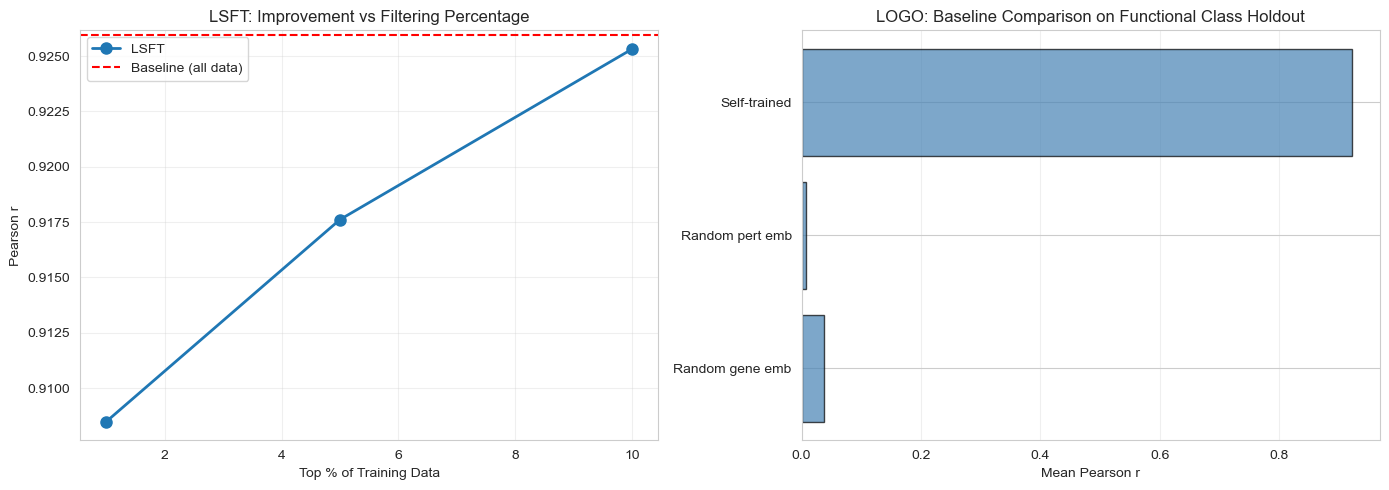

In [22]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LSFT results
if 'lsft_df' in locals() and not lsft_df.empty:
    axes[0].plot(lsft_df["top_pct"]*100, lsft_df["pearson_r"], 'o-', label='LSFT', linewidth=2, markersize=8)
    axes[0].axhline(y=baseline_metrics['pearson_r'], color='r', linestyle='--', label='Baseline (all data)')
    axes[0].set_xlabel('Top % of Training Data')
    axes[0].set_ylabel('Pearson r')
    axes[0].set_title('LSFT: Improvement vs Filtering Percentage')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

# LOGO results
if logo_results:
    logo_summary = pd.concat(logo_results)
    logo_summary_agg = logo_summary.groupby("baseline").agg({
        "pearson_r": "mean",
        "l2": "mean"
    }).reset_index()
    
    axes[1].barh(logo_summary_agg["baseline"], logo_summary_agg["pearson_r"], alpha=0.7, color='steelblue', edgecolor='black')
    axes[1].set_xlabel('Mean Pearson r')
    axes[1].set_title('LOGO: Baseline Comparison on Functional Class Holdout')
    axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


## Summary

### Key Takeaways

1. **LSFT (Local Similarity-Filtered Training)**:
   - Filters training data by similarity in embedding space (using perturbation embeddings B)
   - Retrains the full model (Y = A·K·B) on filtered subsets (top 1%, 5%, 10%)
   - **Important**: Test perturbation must be transformed into the NEW local PCA space (not baseline space)
   - **Important**: Y matrix must be centered before solving: `Y_centered = Y - mean(Y, axis=1)`
   - **Important**: Predictions must add center back: `Y_pred = A @ K @ B_test + center`
   - Trade-off: More similar data vs less training data
   - Performance depends on whether similar perturbations are more informative

2. **LOGO (Functional Class Holdout)**:
   - Tests biological extrapolation by holding out functional classes (e.g., "Transcription")
   - Training = all non-holdout classes, Test = holdout class
   - Stronger test than random splits (evaluates biological knowledge)
   - Key question: Do embeddings enable extrapolation to new functional classes?
   - Results show Self-trained (PCA) outperforms Random embeddings, indicating learned embeddings capture biological structure

3. **Baseline Comparison**:
   - Self-trained (PCA) learns from training data - typically performs best
   - Random embeddings serve as control (should perform worse)
   - Difference indicates how much learned embeddings help for extrapolation

4. **Common Pitfalls**:
   - Forgetting to center Y before solving can lead to poor predictions
   - Using baseline embedding space for test perturbations when retraining on filtered data
   - Not adding center back to predictions

### Next Steps

In the next tutorial (Goal 4), we'll analyze results statistically:
- Compare baselines with paired t-tests
- Aggregate results across datasets
- Visualize performance distributions

---

**Tutorial completed!** Move on to `tutorial_goal_4_analysis.ipynb` for statistical analysis.
